In [151]:
def EFG(X, u, v):
    X_u = X.diff(u)
    X_v = X.diff(v)
    E(u, v) = X_u.dot_product(X_u)
    F(u, v) = X_u.dot_product(X_v)
    G(u, v) = X_v.dot_product(X_v)
    return (E, F, G)


def metric(X, u, v):
    E, F, G = EFG(X, u, v)
    def g(x, y): return matrix([[E(x, y), F(x, y)], [F(x, y), G(x, y)]])
    return g


def sample_metric(g, urange=(-1, 1), vrange=(-1, 1), ucount=5, vcount=5, sq_len=0.2):
    squares = []
    transformed_squares = []

    uspace = np.linspace(urange[0], urange[1], ucount)
    vspace = np.linspace(vrange[0], vrange[1], vcount)
    space = cartesian_product_iterator([uspace, vspace])
    for u, v in space:
        square = matrix([[-sq_len/2, -sq_len/2, sq_len/2, sq_len/2], [-sq_len/2, sq_len/2, sq_len/2, -sq_len/2]])
        translate = matrix([[u, u, u, u], [v, v, v, v]])
        transformed = g(u, v) * square
        
        squares.append(square + translate)
        transformed_squares.append(transformed + translate)

    return squares, transformed_squares

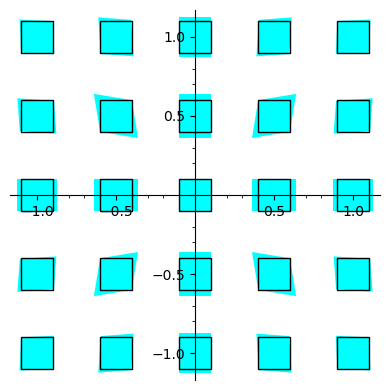

In [154]:
# X(theta, phi) = (cos(theta)*sin(phi),sin(theta)*sin(phi),cos(phi))
# g = metric(X, theta, phi)

# X(u, v) = (u, v, (u^2 + v^2)/2)
X(u, v) = (u, v, 1/(u^2 + v^2 + 1))
g = metric(X, u, v)
squares, transformed_squares = sample_metric(g)

plot = Graphics()
plot += sum([polygon([(x, y) for x, y in transformed.transpose()], color='cyan') for transformed in transformed_squares])
plot += sum([polygon([(x, y) for x, y in square.transpose()], fill=False, color='black') for square in squares])
show(plot)